# Omission LFP Analysis

Brief 1-2 sentence description of notebook.

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import os
import glob
from collections import defaultdict
import re

In [3]:
# Imports of all used packages and libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
from scipy import stats
import itertools
from scipy.stats import linregress

In [4]:
import spikeinterface.extractors as se
import spikeinterface.preprocessing as sp
from spectral_connectivity import Multitaper, Connectivity
import spectral_connectivity

In [5]:
from statsmodels.tsa.stattools import grangercausalitytests


## Inputs & Data

Explanation of each input and where it comes from.

In [37]:
TIME_HALFBANDWIDTH_PRODUCT = 2
TIME_WINDOW_DURATION = 1
TIME_WINDOW_STEP = 0.5


In [6]:
# Define your keywords
KEYWORD_TOP = '_trial_'
KEYWORD_BOTTOM = '_baseline_'

In [7]:
GROUPING = "all"
# GROUPING = "velocity_parsed"

In [8]:
# Inputs and Required data loading
# input varaible names are in all caps snake case
# Whenever an input changes or is used for processing 
# the vairables are all lower in snake case

In [9]:
BBOX_TO_ANCHOR=(1.5, 0.9)
LOC='upper right'

In [10]:
ALL_BANDS = ["theta", "beta", "gamma"]
BAND_TO_FREQ = {"theta": {"low_freq": 4, "high_freq": 12}, "beta": {"low_freq": 13, "high_freq": 30}, "gamma": {"low_freq": 30, "high_freq": 70}}

In [11]:
# variables for LFP extraction
FREQ_MIN=0.5
FREQ_MAX=300
NOTCH_FREQ=60
ORIGINAL_SAMPLE_RATE = 20000
RESAMPLE_RATE=1000
TRIAL_DURATION=10

In [12]:
INPUT_VARIABLE = 1

TIME_HALFBANDWIDTH_PRODUCT = 2
TIME_WINDOW_DURATION = 1
TIME_WINDOW_STEP = 0.5


TRIAL_TIME_STAMP_DURATION = 1000*10

In [13]:
BIN_TO_COLOR = {0: {"baseline": "lightblue", "trial": "blue"}, 1: {"baseline": "lightgreen", "trial": "green"}, 2: {"baseline": "lightcoral", "trial": "red"}}
TRIAL_OR_BASELINE_TO_STYLE = {'baseline': "--", "trial": "-"}
BIN_TO_VELOCITY = {0: "0 to 2.5cm/s", 1: "2.5 to 5cm/s", 2: "5cm/s+"}

In [14]:
NUM_LINES = 3

In [15]:
BASELINE_OUTCOME_TO_COLOR = {
'lose': "red",
'lose_trial': "red",
'lose_baseline': "hotpink",

'omission': "orange",
'omission_trial': "orange",
'omission_baseline': "navajowhite",

'rewarded': "green",
'rewarded_trial': "green",
'rewarded_baseline': "lightgreen",

'win': "blue",
'win_trial': "blue",
'win_baseline': "lightblue"}

In [16]:
TRIAL_OR_BASELINE_TO_STYLE = {'baseline': "--", "trial": "-"}

In [17]:
CHANNEL_MAPPING_DF = pd.read_excel("../../data/channel_mapping.xlsx")
CHANNEL_MAPPING_DF["Subject"] = CHANNEL_MAPPING_DF["Subject"].astype(str)

TONE_TIMESTAMP_DF = pd.read_excel("../../data/rce_tone_timestamp.xlsx", index_col=0)
OUTPUT_DIR = r"./proc" # where data is saved should always be shown in the inputs


In [18]:
def standardize_col_name(col_name, keywords, replacement="_"):
    """
    Standardize the column name by removing specified keywords.

    Parameters:
    col_name (str): The original column name.
    keywords (list of str): A list of keywords to remove from the column name.

    Returns:
    str: The standardized column name.
    """
    for keyword in keywords:
        col_name = col_name.replace(keyword, replacement)
    # Replace any double underscores possibly created and strip leading/trailing underscores
    col_name = col_name.replace('__', '_').strip('_')
    return col_name

## Outputs

Describe each output that the notebook creates. 

- Is it a plot or is it data?

- How valuable is the output and why is it valuable or useful?

## Functions

- Ideally functions are defined here first and then data is processed using the functions
    - function names are short and in snake case all lowercase
    - a function name should be unique but does not have to describe the function
    - doc strings describe functions not function names

In [19]:
def generate_pairs(lst):
    pairs = []
    n = len(lst)
    for i in range(n):
        for j in range(i+1, n):
            pairs.append((lst[i], lst[j]))
    return pairs

In [20]:
def nested_dict():
    return defaultdict(dict)

triple_nested_dict = defaultdict(nested_dict)

## Processing

In [127]:
MERGED_LFP_AND_SLEAP = pd.read_pickle("./proc/full_baseline_and_trial_lfp_traces.pkl")

In [128]:
MERGED_LFP_AND_SLEAP.head()

,time,recording_dir,recording_file,time_stamp_index,video_file,video_frame,video_number,subject_info,competition_closeness,video_name,...,mPFC_baseline_lfp_trace,mPFC_trial_lfp_trace,vHPC_baseline_lfp_trace,vHPC_trial_lfp_trace,BLA_baseline_lfp_trace,BLA_trial_lfp_trace,LH_baseline_lfp_trace,LH_trial_lfp_trace,MD_baseline_lfp_trace,MD_trial_lfp_trace
0,6310663,20221202_134600_omission_and_competition_subje...,20221202_134600_omission_and_competition_subje...,1390826,20221202_134600_omission_and_competition_subje...,1734,1.0,6_1_top_2_base_3,rewarded,20221202_134600_omission_and_competition_subje...,...,"[1.8457601, 1.7363818, 1.6475118, 1.59738, 1.2...","[0.6927297, 0.96389693, 0.7884358, -0.04101689...","[-0.06969439, -0.09568214, -0.05315674, 0.1571...","[1.5864334, 1.5710771, 1.5970649, 1.2155175, 0...","[2.0367627, 2.1163385, 2.1618104, 2.2679114, 2...","[0.3164087, 0.36377528, 0.18757163, -0.5020857...","[3.1382985, 3.2319791, 3.2788196, 3.2881875, 3...","[0.8118982, 1.2209699, 0.87435186, -0.4028264,...","[1.3934726, 1.494771, 1.764077, 1.828315, 1.68...","[-0.9783956, -0.86721426, -0.7288553, -1.40582..."
1,7910662,20221202_134600_omission_and_competition_subje...,20221202_134600_omission_and_competition_subje...,2990825,20221202_134600_omission_and_competition_subje...,3728,1.0,6_1_top_2_base_3,rewarded,20221202_134600_omission_and_competition_subje...,...,"[1.2191132, 1.1348007, 1.2054409, 1.0960625, 0...","[1.0732753, 0.7246318, 0.7633699, 0.3782669, -...","[0.31539667, 0.23152715, 0.29767776, 0.4217101...","[0.03543783, -0.27641505, -0.40044746, -0.6638...","[0.3107247, 0.14209972, -0.05873455, -0.331566...","[0.026525281, -0.04547191, 0.11936376, -0.4092...","[-1.180375, -1.2959143, -1.3771042, -1.458294,...","[0.9492963, 0.46840277, 0.6713773, 0.043717593...","[-0.14577106, -0.16059524, 0.027177656, 0.1680...","[1.6281886, 1.349, 1.4675934, 0.9487473, -0.21..."
2,9710660,20221202_134600_omission_and_competition_subje...,20221202_134600_omission_and_competition_subje...,4790823,20221202_134600_omission_and_competition_subje...,5972,1.0,6_1_top_2_base_3,rewarded,20221202_134600_omission_and_competition_subje...,...,"[-1.2669662, -1.2965895, -1.2532939, -0.986684...","[0.28711826, 0.84996116, 1.0960625, 0.8226166,...","[-1.2556804, -1.2580429, -1.3312811, -1.118654...","[0.060244307, 0.4748669, 0.7654571, 0.6591436,...","[-1.9912907, -1.9041362, -1.9325562, -1.542255...","[0.69344664, 1.4001559, 1.7582471, 1.4304705, ...","[-0.19985186, -0.074944444, -0.18423842, -0.13...","[-0.59643286, 0.27167362, 0.6901134, 0.4371759...","[-0.32119048, -0.52872896, -0.96851283, -0.753...","[0.096357144, 0.88450915, 1.2131118, 0.8943919..."
3,11310658,20221202_134600_omission_and_competition_subje...,20221202_134600_omission_and_competition_subje...,6390821,20221202_134600_omission_and_competition_subje...,7966,1.0,6_1_top_2_base_3,omission,20221202_134600_omission_and_competition_subje...,...,"[-2.0257788, -2.0348935, -1.9323514, -1.754611...","[2.376701, 2.3015034, 1.7796774, 0.9411098, 0....","[0.16655779, 0.42879772, 0.66268736, 0.6934002...","[-1.8427671, -2.303459, -2.6802812, -3.060647,...","[-1.2637402, -1.0382752, -0.82986236, -0.74649...","[2.6771586, 2.3929594, 2.209177, 1.9761335, 1....","[-2.538743, -2.1983705, -1.8673657, -1.7143542...","[2.8447661, 2.3045416, 1.5301157, 0.96490973, ...","[-2.7647088, -2.5546997, -2.3051593, -2.055619...","[2.087738, 1.7418406, 1.1266373, 0.45954946, 0..."
4,12810657,20221202_134600_omission_and_competition_subje...,20221202_134600_omission_and_competition_subje...,7890820,20221202_134600_omission_and_competition_subje...,9836,1.0,6_1_top_2_base_3,rewarded,20221202_134600_omission_and_competition_subje...,...,"[-0.5765152, 0.25749493, 0.6403192, 0.4375135,...","[-0.043295607, 0.73602533, 0.31674156, 0.07747...","[-0.31421542, 0.19727057, 0.4453354, 0.3744597...","[0.21617076, 0.8221576, 0.58236164, 0.43116024...","[-2.1352851, -2.0576038, -2.0822346, -2.140969...","[-0.18188764, 0.113

In [129]:
trace_columns = [col for col in MERGED_LFP_AND_SLEAP.columns if "trace" in col]

In [130]:
id_cols = [col for col in MERGED_LFP_AND_SLEAP.columns if col not in trace_columns]

In [131]:
trace_columns

['mPFC_baseline_lfp_trace',
 'mPFC_trial_lfp_trace',
 'vHPC_baseline_lfp_trace',
 'vHPC_trial_lfp_trace',
 'BLA_baseline_lfp_trace',
 'BLA_trial_lfp_trace',
 'LH_baseline_lfp_trace',
 'LH_trial_lfp_trace',
 'MD_baseline_lfp_trace',
 'MD_trial_lfp_trace']

In [132]:
MERGED_LFP_AND_SLEAP = MERGED_LFP_AND_SLEAP.reset_index()

## Coherece Calculation

- Getting the brain region pairs

In [133]:
trial_trace_columns = sorted([col for col in MERGED_LFP_AND_SLEAP.columns if "trial_lfp_trace" in col])
baseline_trace_columns = sorted([col for col in MERGED_LFP_AND_SLEAP.columns if "baseline_lfp_trace" in col])

In [134]:
trial_trace_columns

['BLA_trial_lfp_trace',
 'LH_trial_lfp_trace',
 'MD_trial_lfp_trace',
 'mPFC_trial_lfp_trace',
 'vHPC_trial_lfp_trace']

In [135]:
trial_brain_region_pairs = generate_pairs(trial_trace_columns)
trial_brain_region_pairs = sorted(trial_brain_region_pairs)
baseline_brain_region_pairs = generate_pairs(baseline_trace_columns)
baseline_brain_region_pairs = sorted(baseline_brain_region_pairs)

In [136]:
trial_brain_region_pairs

[('BLA_trial_lfp_trace', 'LH_trial_lfp_trace'),
 ('BLA_trial_lfp_trace', 'MD_trial_lfp_trace'),
 ('BLA_trial_lfp_trace', 'mPFC_trial_lfp_trace'),
 ('BLA_trial_lfp_trace', 'vHPC_trial_lfp_trace'),
 ('LH_trial_lfp_trace', 'MD_trial_lfp_trace'),
 ('LH_trial_lfp_trace', 'mPFC_trial_lfp_trace'),
 ('LH_trial_lfp_trace', 'vHPC_trial_lfp_trace'),
 ('MD_trial_lfp_trace', 'mPFC_trial_lfp_trace'),
 ('MD_trial_lfp_trace', 'vHPC_trial_lfp_trace'),
 ('mPFC_trial_lfp_trace', 'vHPC_trial_lfp_trace')]

In [137]:
baseline_brain_region_pairs

[('BLA_baseline_lfp_trace', 'LH_baseline_lfp_trace'),
 ('BLA_baseline_lfp_trace', 'MD_baseline_lfp_trace'),
 ('BLA_baseline_lfp_trace', 'mPFC_baseline_lfp_trace'),
 ('BLA_baseline_lfp_trace', 'vHPC_baseline_lfp_trace'),
 ('LH_baseline_lfp_trace', 'MD_baseline_lfp_trace'),
 ('LH_baseline_lfp_trace', 'mPFC_baseline_lfp_trace'),
 ('LH_baseline_lfp_trace', 'vHPC_baseline_lfp_trace'),
 ('MD_baseline_lfp_trace', 'mPFC_baseline_lfp_trace'),
 ('MD_baseline_lfp_trace', 'vHPC_baseline_lfp_trace'),
 ('mPFC_baseline_lfp_trace', 'vHPC_baseline_lfp_trace')]

- Calculating the granger

In [138]:
MERGED_LFP_AND_SLEAP = MERGED_LFP_AND_SLEAP

In [141]:
for region_1, region_2 in trial_brain_region_pairs:
    region_1_trimmed = region_1.split("_")[0]
    region_2_trimmed = region_2.split("_")[0]
    pair_base_name = "{}_{}".format(region_1_trimmed, region_2_trimmed)
    print(pair_base_name)
    try:
        multitaper_col = "{}_trial_multitaper".format(pair_base_name)
        MERGED_LFP_AND_SLEAP[multitaper_col] = MERGED_LFP_AND_SLEAP.apply(lambda x: Multitaper(time_series=np.array([x[region_1],x[region_2]]).T, sampling_frequency=RESAMPLE_RATE, time_halfbandwidth_product=TIME_HALFBANDWIDTH_PRODUCT, time_window_step=TIME_WINDOW_STEP, time_window_duration=TIME_WINDOW_DURATION), axis=1)
    
        connectivity_col = "{}_trial_connectivity".format(pair_base_name)
        MERGED_LFP_AND_SLEAP[connectivity_col] = MERGED_LFP_AND_SLEAP[multitaper_col].apply(lambda x: Connectivity.from_multitaper(x))
        
        MERGED_LFP_AND_SLEAP["{}_trial_frequencies".format(pair_base_name)] = MERGED_LFP_AND_SLEAP[connectivity_col].apply(lambda x: x.frequencies)

        MERGED_LFP_AND_SLEAP["{}_{}_granger".format(region_1_trimmed, region_2_trimmed)] = MERGED_LFP_AND_SLEAP[connectivity_col].apply(lambda x: np.nanmean(x.pairwise_spectral_granger_prediction()[:,:100,0,1], axis=0))

        MERGED_LFP_AND_SLEAP["{}_{}_granger".format(region_2_trimmed, region_1_trimmed)] = MERGED_LFP_AND_SLEAP[connectivity_col].apply(lambda x: np.nanmean(x.pairwise_spectral_granger_prediction()[:,:100,1,0], axis=0))
    
    except Exception as e: 
        print(e)

BLA_LH
BLA_MD
BLA_mPFC
BLA_vHPC
LH_MD


Maximum iterations reached. 18 of 19 converged
Maximum iterations reached. 18 of 19 converged


LH_mPFC
LH_vHPC
MD_mPFC
MD_vHPC
mPFC_vHPC


In [140]:
MERGED_LFP_AND_SLEAP

,index,time,recording_dir,recording_file,time_stamp_index,video_file,video_frame,video_number,subject_info,competition_closeness,...,MD_vHPC_trial_multitaper,MD_vHPC_trial_connectivity,MD_vHPC_trial_frequencies,MD_trial_lfp_trace_vHPC_trial_lfp_trace_granger,vHPC_trial_lfp_trace_MD_trial_lfp_trace_granger,mPFC_vHPC_trial_multitaper,mPFC_vHPC_trial_connectivity,mPFC_vHPC_trial_frequencies,mPFC_trial_lfp_trace_vHPC_trial_lfp_trace_granger,vHPC_trial_lfp_trace_mPFC_trial_lfp_trace_granger
0,0,6310663,20221202_134600_omission_and_competition_subje...,20221202_134600_omission_and_competition_subje...,1390826,20221202_134600_omission_and_competition_subje...,1734,1.0,6_1_top_2_base_3,rewarded,...,"Multitaper(sampling_frequency=1000, time_halfb...",<spectral_connectivity.connectivity.Connectivi...,"[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[0.7049374822552316, 0.569103487559232, 0.3553...","[1.0519928459798682, 0.7671643482661273, 0.418...","Multitaper(sampling_frequency=1000, time_halfb...",<spectral_connectivity.connectivity.Connectivi...,"[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[0.4625535331996613, 0.6263526202855292, 0.462...","[1.0381965369018873, 0.41353594522379195, 0.37..."
1,1,7910662,20221202_134600_omission_and_competition_subje...,20221202_134600_omission_and_competition_subje...,2990825,20221202_134600_omission_and_competition_subje...,3728,1.0,6_1_top_2_base_3,rewarded,...,"Multitaper(sampling_frequency=1000, time_halfb...",<spectral_connectivity.connectivity.Connectivi...,"[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[1.1753055224004236, 0.44796558878013637, 0.39...","[0.8222652644326032, 0.5492264203916145, 0.769...","Multitaper(sampling_frequency=1000, time_halfb...",<spectral_connectivity.connectivity.Connectivi...,"[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[0.7411404972819997, 0.3680557652929181, 0.332...","[0.9182432303640228, 0.5449124996991966, 0.641..."
2,2,9710660,20221202_134600_omission_and_competition_subje...,20221202_134600_omission_and_competition_subje...,4790823,20221202_134600_omission_and_competition_subje...,5972,1.0,6_1_top_2_base_3,rewarded,...,"Multitaper(sampling_frequency=1000, time_halfb...",<spectral_connectivity.connectivity.Connectivi...,"[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[0.4494122105238897, 0.5568542070933786, 0.500...","[0.4506494412290113, 0.7682445213888202, 0.681...","Multitaper(sampling_frequency=1000, time_halfb...",<spectral_connectivity.connectivity.Connectivi...,"[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[0.9669003408407951, 0.5641924614370438, 0.482...","[0.7621941859135439, 0.7802103384052453, 0.671..."
3,3,11310658,20221202_134600_omission_and_competition_subje...,20221202_134600_omission_and_competition_subje...,6390821,20221202_134600_omission_and_competition_subje...,7966,1.0,6_1_top_2_base_3,omission,...,"Multitaper(sampling_frequency=1000, time_halfb...",<spectral_connectivity.connectivity.Connectivi...,"[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[0.31003400725334573, 0.4656146470600471, 0.47...","[0.8083129787083652, 0.6985535359046473, 0.526...","Multitaper(sampling_frequency=1000, time_halfb...",<spectral_connectivity.connectivity.Connectivi...,"[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[0.400195941353913, 0.24594522206742195, 0.292...","[1.1605780970412434, 0.7323261284396144, 0.585..."
4,4,12810657,20221202_134600_omission_and_competition_subje...,20221202_134600_omission_and_competition_subje...,7890820,20221202_134600_omission_and_competition_subje...,9836,1.0,6_1_top_2_base_3,rewarded,...,"Multitaper(sampling_frequency=1000, time_halfb...",<spectral_connectivity.connectivity.Connectivi...,"[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[0.25351655625486413, 0.44050978838147914, 0.4...","[1.135595199854731, 0.8050550315779412, 0.6456...","Multitaper(sampling_frequency=1000, time_halfb...",<spectral_connectivity.connectivity.Connectivi...,"[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7

In [123]:
GROUPINGS = "trial_outcome"

In [151]:
all_frequencies = MERGED_LFP_AND_SLEAP["BLA_LH_trial_frequencies"].iloc[0][:100]

In [153]:
grouped_all_trials_df

,trial_outcome,mPFC_trial_lfp_trace_vHPC_trial_lfp_trace_granger,mean_granger,std_granger,n_trials,sem_granger
0,omission,"[[0.400195941353913, 0.24594522206742195, 0.29...","[0.400195941353913, 0.24594522206742195, 0.292...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,rewarded,"[[0.4625535331996613, 0.6263526202855292, 0.46...","[0.6617309674375391, 0.5160984247332333, 0.393...","[0.2082543966606975, 0.09551421078637211, 0.08...","[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, ...","[0.10412719833034875, 0.047757105393186054, 0...."


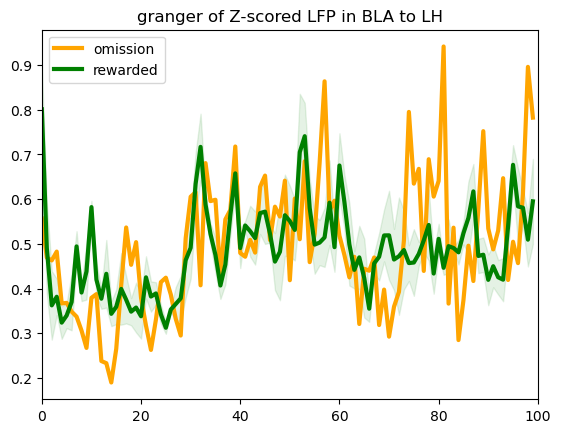

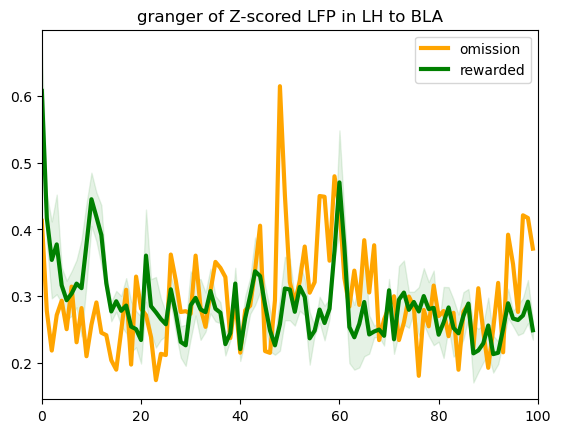

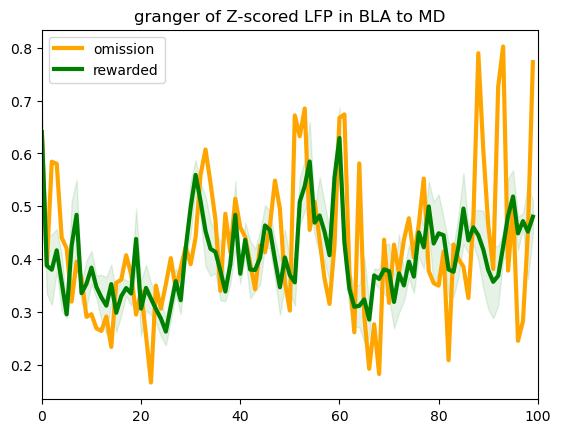

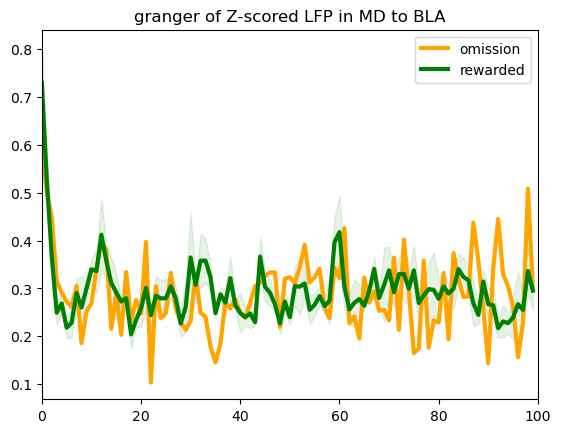

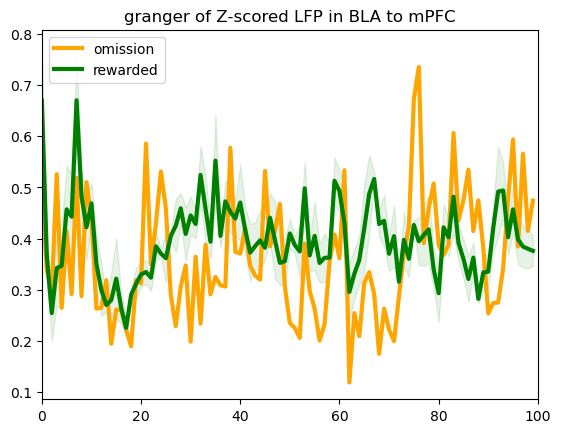

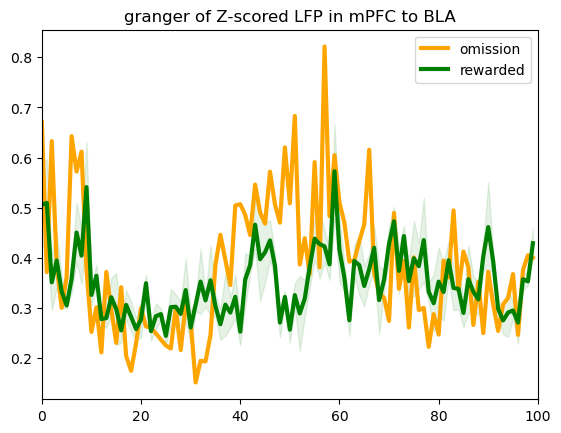

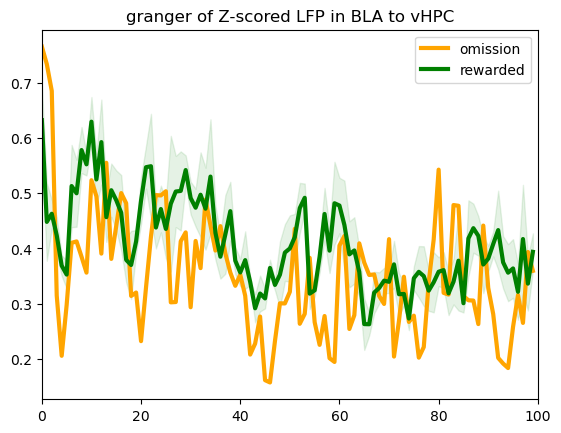

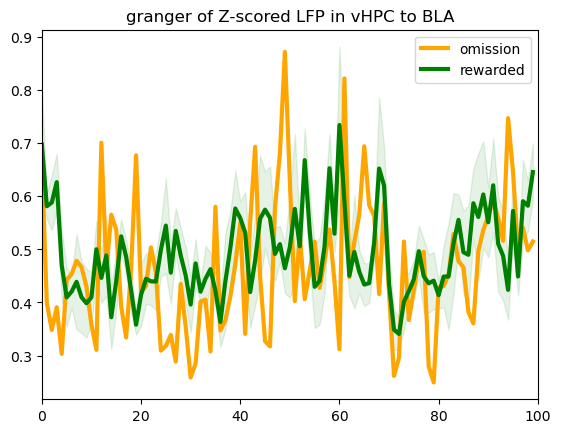

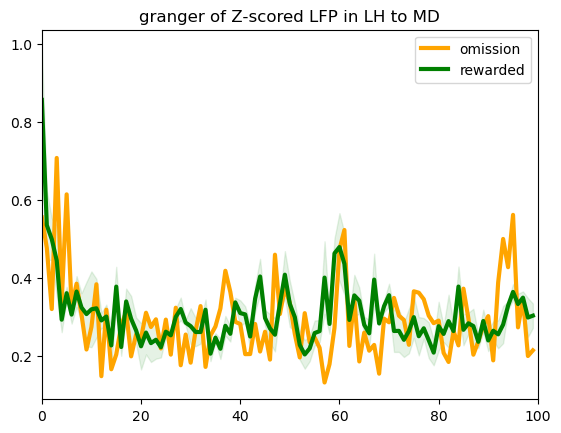

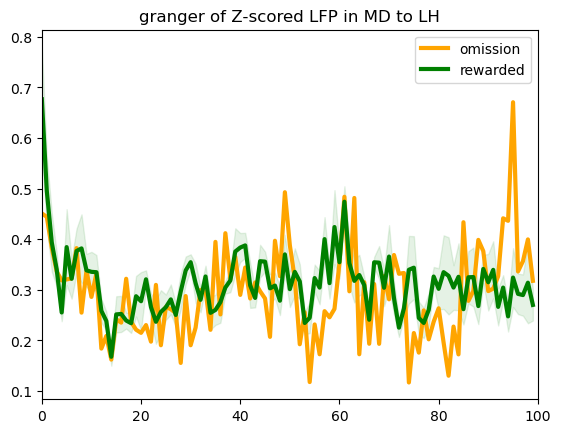

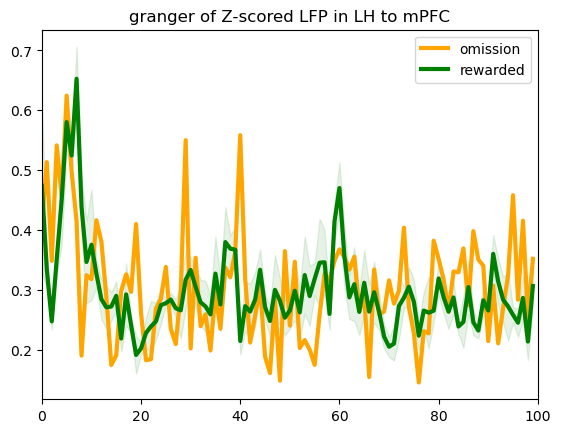

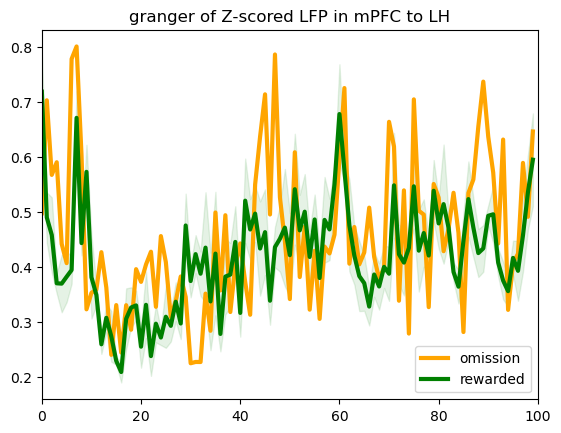

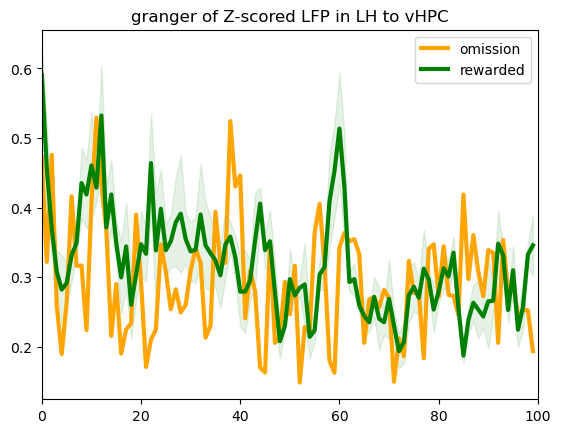

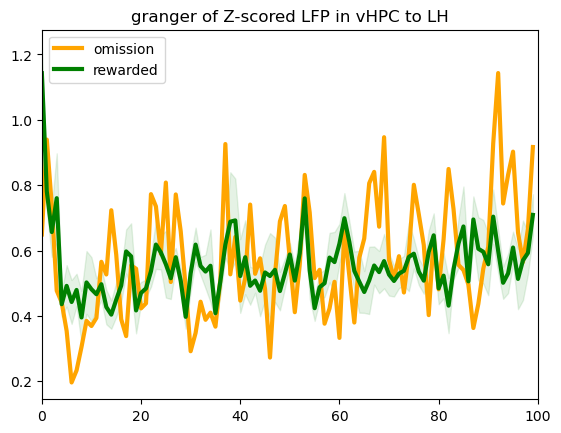

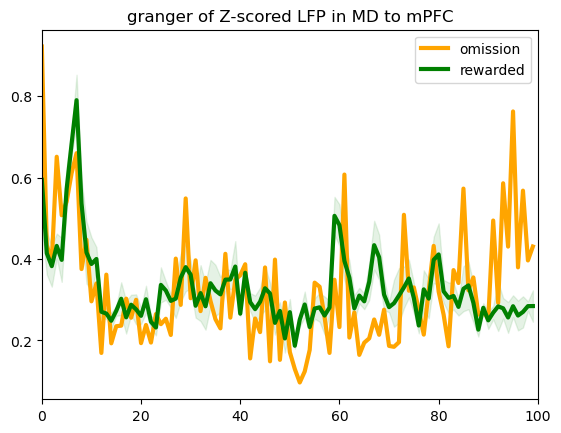

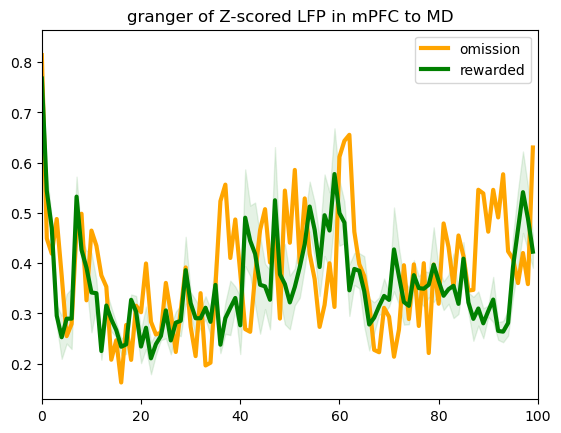

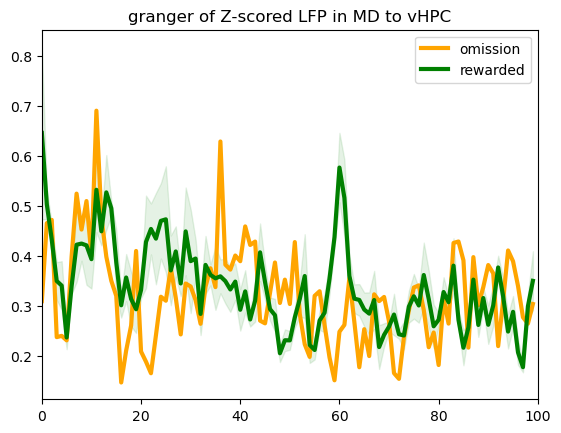

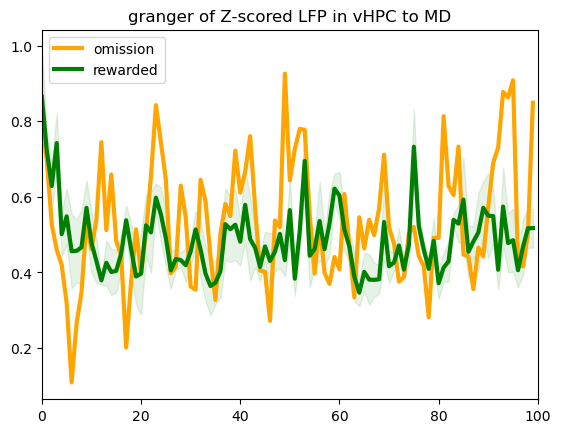

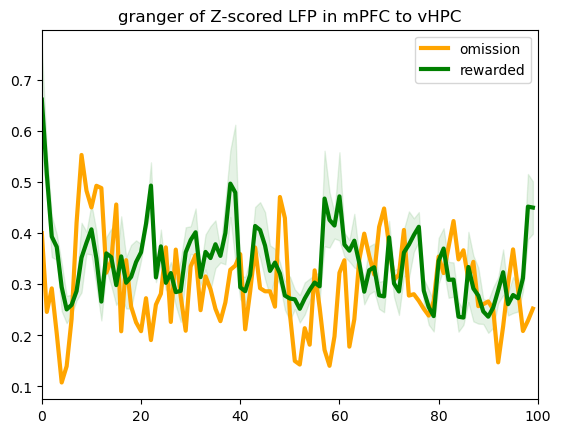

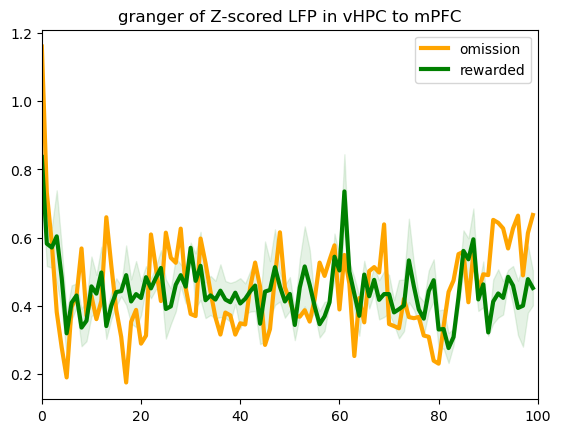

In [157]:
low_freq = 0
high_freq = 100

for region_1, region_2 in trial_brain_region_pairs:
    region_1_trimmed = region_1.split("_")[0]
    region_2_trimmed = region_2.split("_")[0]
    
    
    fig, ax = plt.subplots()
    plt.title("granger of Z-scored LFP in {} to {}".format(region_1_trimmed, region_2_trimmed))
    plt.xlim(low_freq, high_freq)

    
    granger_col = "{}_{}_granger".format(region_1, region_2)
    grouped_all_trials_df = MERGED_LFP_AND_SLEAP.groupby([GROUPINGS]).agg({granger_col: lambda x: np.vstack(x.tolist())}).reset_index()
    # grouped_all_trials_df = grouped_all_trials_df[grouped_all_trials_df["trial_or_baseline"] == "trial"]
    grouped_all_trials_df["mean_granger"] = grouped_all_trials_df[granger_col].apply(lambda x: np.nanmean(np.vstack(x), axis=0))
    grouped_all_trials_df["std_granger"] = grouped_all_trials_df[granger_col].apply(lambda x: np.nanstd(np.vstack(x), axis=0))
    grouped_all_trials_df["n_trials"] = grouped_all_trials_df[granger_col].apply(lambda x: np.sum(~np.isnan(x), axis=0))
    grouped_all_trials_df["sem_granger"] = grouped_all_trials_df.apply(lambda x: x["std_granger"] / np.sqrt(x["n_trials"]), axis=1)
    for index, row in grouped_all_trials_df.iterrows():
        try:

            ax = sns.lineplot(x=all_frequencies, y=row["mean_granger"], \
            label="{}".format(row[GROUPINGS]), color=BASELINE_OUTCOME_TO_COLOR[row[GROUPINGS]],
            linewidth=3)

    
    
            plt.fill_between(all_frequencies, \
            row["mean_granger"] - row["sem_granger"], row["mean_granger"] + row["sem_granger"], alpha=0.1,
            color=BASELINE_OUTCOME_TO_COLOR[row[GROUPINGS]])
        except Exception as e: 
            print(e)
    plt.show()
    
    fig, ax = plt.subplots()
    plt.title("granger of Z-scored LFP in {} to {}".format(region_2_trimmed, region_1_trimmed))
    plt.xlim(low_freq, high_freq)

    
    granger_col = "{}_{}_granger".format(region_2, region_1)
    grouped_all_trials_df = MERGED_LFP_AND_SLEAP.groupby([GROUPINGS]).agg({granger_col: lambda x: np.vstack(x.tolist())}).reset_index()
    # grouped_all_trials_df = grouped_all_trials_df[grouped_all_trials_df["trial_or_baseline"] == "trial"]
    grouped_all_trials_df["mean_granger"] = grouped_all_trials_df[granger_col].apply(lambda x: np.nanmean(np.vstack(x), axis=0))
    grouped_all_trials_df["std_granger"] = grouped_all_trials_df[granger_col].apply(lambda x: np.nanstd(np.vstack(x), axis=0))
    grouped_all_trials_df["n_trials"] = grouped_all_trials_df[granger_col].apply(lambda x: np.sum(~np.isnan(x), axis=0))
    grouped_all_trials_df["sem_granger"] = grouped_all_trials_df.apply(lambda x: x["std_granger"] / np.sqrt(x["n_trials"]), axis=1)
    for index, row in grouped_all_trials_df.iterrows():
        try:

            ax = sns.lineplot(x=all_frequencies, y=row["mean_granger"], \
            label="{}".format(row[GROUPINGS]), color=BASELINE_OUTCOME_TO_COLOR[row[GROUPINGS]],
            linewidth=3)

    
    
            plt.fill_between(all_frequencies, \
            row["mean_granger"] - row["sem_granger"], row["mean_granger"] + row["sem_granger"], alpha=0.1,
            color=BASELINE_OUTCOME_TO_COLOR[row[GROUPINGS]])
        except Exception as e: 
            print(e)
    
    


In [158]:
raise ValueError()

ValueError: 

In [119]:
pair_base_name

'mPFC_vHPC'

In [ ]:
low_freq =30
high_freq = 90
for pair_base_name in all_pair_base_name:
    print(pair_base_name)
    
    fig, ax = plt.subplots()
    plt.title("granger of Z-scored LFP in {}".format(pair_base_name))
    plt.xlabel("Frequency")
    plt.ylabel("granger of Z-scored LFP")
    plt.xlim(low_freq, high_freq)
    plt.xticks(np.arange(low_freq, high_freq+1, 5))
    plt.yticks(np.arange(0, 1, 0.1))
    plt.ylim(0,1)
    plt.grid()

    for trial_or_baseline in TRIAL_AND_BASELINE:

        granger_col = "{}_{}_granger_magnitude".format(pair_base_name, trial_or_baseline)
        grouped_all_trials_df = channel_map_and_all_trials_df.groupby([GROUPINGS]).agg({granger_col: lambda x: np.vstack(x.tolist())}).reset_index()
        # grouped_all_trials_df = grouped_all_trials_df[grouped_all_trials_df["trial_or_baseline"] == "trial"]
        grouped_all_trials_df["mean_granger"] = grouped_all_trials_df[granger_col].apply(lambda x: np.nanmean(np.vstack(x), axis=0))
        grouped_all_trials_df["std_granger"] = grouped_all_trials_df[granger_col].apply(lambda x: np.nanstd(np.vstack(x), axis=0))
        grouped_all_trials_df["n_trials"] = grouped_all_trials_df[granger_col].apply(lambda x: np.sum(~np.isnan(x), axis=0))
        grouped_all_trials_df["sem_granger"] = grouped_all_trials_df.apply(lambda x: x["std_granger"] / np.sqrt(x["n_trials"]), axis=1)
        for index, row in grouped_all_trials_df.iterrows():
            try:
                if trial_or_baseline == "trial":
                    ax = sns.lineplot(x=all_frequencies, y=row["mean_granger"], \
                label="{} {}".format(row[GROUPINGS], trial_or_baseline), color=BASELINE_OUTCOME_TO_COLOR[row[GROUPINGS]],
                linestyle=TRIAL_OR_BASELINE_TO_STYLE[trial_or_baseline], linewidth=3)
                else:
                    ax = sns.lineplot(x=all_frequencies, y=row["mean_granger"], \
                color=BASELINE_OUTCOME_TO_COLOR[row[GROUPINGS]],
                linestyle=TRIAL_OR_BASELINE_TO_STYLE[trial_or_baseline], linewidth=3)
                

    
                plt.fill_between(all_frequencies, \
                row["mean_granger"] - row["sem_granger"], row["mean_granger"] + row["sem_granger"], alpha=0.1,
                color=BASELINE_OUTCOME_TO_COLOR[row[GROUPINGS]])
            except Exception as e: 
                print(e)


    
    # plt.savefig("./proc/granger/{}_{}hz_{}_granger_of_zscored_lfp.png".format(low_freq, high_freq, pair_base_name))
    plt.show()
    
    
    

    

In [117]:
raise ValueError()

ValueError: 

In [116]:
MERGED_LFP_AND_SLEAP

,index,time,recording_dir,recording_file,time_stamp_index,video_file,video_frame,video_number,subject_info,competition_closeness,...,LH_trial_lfp_trace_mPFC_trial_lfp_trace_granger,mPFC_trial_lfp_trace_LH_trial_lfp_trace_granger,LH_trial_lfp_trace_vHPC_trial_lfp_trace_granger,vHPC_trial_lfp_trace_LH_trial_lfp_trace_granger,MD_trial_lfp_trace_mPFC_trial_lfp_trace_granger,mPFC_trial_lfp_trace_MD_trial_lfp_trace_granger,MD_trial_lfp_trace_vHPC_trial_lfp_trace_granger,vHPC_trial_lfp_trace_MD_trial_lfp_trace_granger,mPFC_trial_lfp_trace_vHPC_trial_lfp_trace_granger,vHPC_trial_lfp_trace_mPFC_trial_lfp_trace_granger
0,0,6310663,20221202_134600_omission_and_competition_subje...,20221202_134600_omission_and_competition_subje...,1390826,20221202_134600_omission_and_competition_subje...,1734,1.0,6_1_top_2_base_3,rewarded,...,"[0.34779405664665924, 0.2599665926944268, 0.23...","[0.8681887653615682, 0.3995841192687841, 0.257...","[0.6599607495419402, 0.644581074885393, 0.3621...","[1.2003386844630215, 0.7291818880205758, 0.441...","[0.7559861560114569, 0.460947045669302, 0.5515...","[0.8509193071356373, 0.47670501656433667, 0.45...","[0.7049374822552316, 0.569103487559232, 0.3553...","[1.0519928459798682, 0.7671643482661273, 0.418...","[0.4625535331996613, 0.6263526202855292, 0.462...","[1.0381965369018873, 0.41353594522379195, 0.37..."
1,1,7910662,20221202_134600_omission_and_competition_subje...,20221202_134600_omission_and_competition_subje...,2990825,20221202_134600_omission_and_competition_subje...,3728,1.0,6_1_top_2_base_3,rewarded,...,"[0.4669663507576109, 0.4337512093101336, 0.210...","[0.5761242586323513, 0.39851005641551734, 0.43...","[0.5792367940443409, 0.3220436179666186, 0.244...","[0.8649213302070472, 0.6789667423939955, 0.635...","[0.7290491417037237, 0.4918339540872885, 0.324...","[0.8900376916711146, 0.4974518593049305, 0.486...","[1.1753055224004236, 0.44796558878013637, 0.39...","[0.8222652644326032, 0.5492264203916145, 0.769...","[0.7411404972819997, 0.3680557652929181, 0.332...","[0.9182432303640228, 0.5449124996991966, 0.641..."
2,2,9710660,20221202_134600_omission_and_competition_subje...,20221202_134600_omission_and_competition_subje...,4790823,20221202_134600_omission_and_competition_subje...,5972,1.0,6_1_top_2_base_3,rewarded,...,"[0.9320594510218996, 0.3076232763422125, 0.288...","[0.8499402724187481, 0.5581659137954518, 0.637...","[0.6619087464437843, 0.44930175562602115, 0.44...","[1.2179678584808151, 0.9760226222679196, 0.869...","[0.7428569912129253, 0.4694208861551508, 0.290...","[0.7696393097345624, 0.6621860236145787, 0.422...","[0.4494122105238897, 0.5568542070933786, 0.500...","[0.4506494412290113, 0.7682445213888202, 0.681...","[0.9669003408407951, 0.5641924614370438, 0.482...","[0.7621941859135439, 0.7802103384052453, 0.671..."
3,3,11310658,20221202_134600_omission_and_competition_subje...,20221202_134600_omission_and_competition_subje...,6390821,20221202_134600_omission_and_competition_subje...,7966,1.0,6_1_top_2_base_3,omission,...,"[0.4129973087504267, 0.513674219491486, 0.3488...","[0.4969198429960255, 0.7022735392954016, 0.566...","[0.47232705381631784, 0.321838686879263, 0.475...","[0.6490814916768737, 0.9393290270559845, 0.738...","[0.9221949798903485, 0.4344715038774783, 0.392...","[0.8141661644352401, 0.44904327421592555, 0.41...","[0.31003400725334573, 0.4656146470600471, 0.47...","[0.8083129787083652, 0.6985535359046473, 0.526...","[0.400195941353913, 0.24594522206742195, 0.292...","[1.1605780970412434, 0.7323261284396144, 0.585..."
4,4,12810657,20221202_134600_omission_and_competition_subje...,20221202_134600_omission_and_competition_subje...,7890820,20221202_134600_omission_and_competition_subje...,9836,1.0,6_1_top_2_base_3,rewarded,...,"[0.1500940543366186, 0.3369880269081814, 0.255...","[0.577587422204942, 0.6005832316184465, 0.4995...","[0.46059236737605896, 0.4083035437871339, 0.42...","[1.2864121526327974, 0.7384606471703333, 0.679...","[0.15080598410940116, 0.2342707258831372, 0.36.

In [73]:
MERGED_LFP_AND_SLEAP["BLA_trial_lfp_trace"]

0    [0.3164087, 0.36377528, 0.18757163, -0.5020857...
1    [0.026525281, -0.04547191, 0.11936376, -0.4092...
2    [0.69344664, 1.4001559, 1.7582471, 1.4304705, ...
3    [2.6771586, 2.3929594, 2.209177, 1.9761335, 1....
4    [-0.18188764, 0.113679774, -0.66123736, -0.935...
Name: BLA_trial_lfp_trace, dtype: object

In [74]:
MERGED_LFP_AND_SLEAP

,index,time,recording_dir,recording_file,time_stamp_index,video_file,video_frame,video_number,subject_info,competition_closeness,...,vHPC_trial_lfp_trace,BLA_baseline_lfp_trace,BLA_trial_lfp_trace,LH_baseline_lfp_trace,LH_trial_lfp_trace,MD_baseline_lfp_trace,MD_trial_lfp_trace,BLA_LH_trial_multitaper,BLA_LH_trial_connectivity,BLA_LH_trial_frequencies
0,0,6310663,20221202_134600_omission_and_competition_subje...,20221202_134600_omission_and_competition_subje...,1390826,20221202_134600_omission_and_competition_subje...,1734,1.0,6_1_top_2_base_3,rewarded,...,"[1.5864334, 1.5710771, 1.5970649, 1.2155175, 0...","[2.0367627, 2.1163385, 2.1618104, 2.2679114, 2...","[0.3164087, 0.36377528, 0.18757163, -0.5020857...","[3.1382985, 3.2319791, 3.2788196, 3.2881875, 3...","[0.8118982, 1.2209699, 0.87435186, -0.4028264,...","[1.3934726, 1.494771, 1.764077, 1.828315, 1.68...","[-0.9783956, -0.86721426, -0.7288553, -1.40582...","Multitaper(sampling_frequency=1000, time_halfb...",<spectral_connectivity.connectivity.Connectivi...,"[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ..."
1,1,7910662,20221202_134600_omission_and_competition_subje...,20221202_134600_omission_and_competition_subje...,2990825,20221202_134600_omission_and_competition_subje...,3728,1.0,6_1_top_2_base_3,rewarded,...,"[0.03543783, -0.27641505, -0.40044746, -0.6638...","[0.3107247, 0.14209972, -0.05873455, -0.331566...","[0.026525281, -0.04547191, 0.11936376, -0.4092...","[-1.180375, -1.2959143, -1.3771042, -1.458294,...","[0.9492963, 0.46840277, 0.6713773, 0.043717593...","[-0.14577106, -0.16059524, 0.027177656, 0.1680...","[1.6281886, 1.349, 1.4675934, 0.9487473, -0.21...","Multitaper(sampling_frequency=1000, time_halfb...",<spectral_connectivity.connectivity.Connectivi...,"[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ..."
2,2,9710660,20221202_134600_omission_and_competition_subje...,20221202_134600_omission_and_competition_subje...,4790823,20221202_134600_omission_and_competition_subje...,5972,1.0,6_1_top_2_base_3,rewarded,...,"[0.060244307, 0.4748669, 0.7654571, 0.6591436,...","[-1.9912907, -1.9041362, -1.9325562, -1.542255...","[0.69344664, 1.4001559, 1.7582471, 1.4304705, ...","[-0.19985186, -0.074944444, -0.18423842, -0.13...","[-0.59643286, 0.27167362, 0.6901134, 0.4371759...","[-0.32119048, -0.52872896, -0.96851283, -0.753...","[0.096357144, 0.88450915, 1.2131118, 0.8943919...","Multitaper(sampling_frequency=1000, time_halfb...",<spectral_connectivity.connectivity.Connectivi...,"[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ..."
3,3,11310658,20221202_134600_omission_and_competition_subje...,20221202_134600_omission_and_competition_subje...,6390821,20221202_134600_omission_and_competition_subje...,7966,1.0,6_1_top_2_base_3,omission,...,"[-1.8427671, -2.303459, -2.6802812, -3.060647,...","[-1.2637402, -1.0382752, -0.82986236, -0.74649...","[2.6771586, 2.3929594, 2.209177, 1.9761335, 1....","[-2.538743, -2.1983705, -1.8673657, -1.7143542...","[2.8447661, 2.3045416, 1.5301157, 0.96490973, ...","[-2.7647088, -2.5546997, -2.3051593, -2.055619...","[2.087738, 1.7418406, 1.1266373, 0.45954946, 0...","Multitaper(sampling_frequency=1000, time_halfb...",<spectral_connectivity.connectivity.Connectivi...,"[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ..."
4,4,12810657,20221202_134600_omission_and_competition_subje...,20221202_134600_omission_and_competition_subje...,7890820,20221202_134600_omission_and_competition_subje...,9836,1.0,6_1_top_2_base_3,rewarded,...,"[0.21617076, 0.8221576, 0.58236164, 0.43116024...","[-2.1352851, -2.0576038, -2.0822346, -2.140969...","[-0.18188764, 0.113679774, -0.66123736, -0.935...","[-2.1671436, -1.4832754, -1.0554676, -1.130412...","[0.5339792, 1.5113796, 0.57145137, -0.02810416...","[-2.0111465, -1.714663, -1.4255916, -1.3662949...","[0.31871977, 1.008044, 0.25942308, -0.22730403...","Multitaper(sampling_frequency=1000, time_halfb...",<spectral_connectivity.connectivity.Connectivi...,"[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ..."


In [79]:
example = MERGED_LFP_AND_SLEAP["BLA_LH_trial_connectivity"].iloc[0].pairwise_spectral_granger_prediction()

In [75]:
example = MERGED_LFP_AND_SLEAP["BLA_LH_trial_connectivity"].iloc[0]

In [82]:
example.shape

(19, 500, 2, 2)

In [103]:
example[:,:100][0][1][0]

array([       nan, 0.15138614])

In [108]:
example[:,:100][0][4][1]

array([0.14789214,        nan])

In [94]:
example[:,:100,1,0].mean(axis=0)

array([       nan, 0.36440832, 0.19903912, 0.22320785, 0.2617046 ,
       0.34158817, 0.38913506, 0.25556949, 0.22541557, 0.2451234 ,
       0.37164276,        nan, 0.47532581, 0.31692202, 0.23855351,
       0.27603268, 0.24383197, 0.19738217, 0.13739655, 0.18298692,
       0.26573104, 0.53968503, 0.31238836, 0.45042758, 0.21597515,
       0.2098721 , 0.37805403, 0.28273995, 0.29983909, 0.32948678,
       0.29746032, 0.38045452, 0.36785093, 0.33702625, 0.29407592,
       0.30119644, 0.30557576, 0.17996951, 0.23026343, 0.39673081,
       0.20393218, 0.20915503, 0.21953688, 0.43196771, 0.30511484,
       0.34765802, 0.21394562, 0.24339494, 0.24874661, 0.20342567,
       0.24957796, 0.28420151, 0.2259525 , 0.31786125, 0.37051992,
       0.23268549, 0.29900185, 0.25396325, 0.30717554, 0.37157945,
       0.4628942 , 0.38780375, 0.4251201 ,        nan, 0.411234  ,
       0.572542  , 0.28871747, 0.23847635, 0.2806848 , 0.21076682,
       0.25791799, 0.29543064, 0.34949828, 0.38864236, 0.37068

In [95]:
example[:,:100,0,1].mean(axis=0)

array([       nan, 0.33913819, 0.16108948, 0.30467205,        nan,
       0.29394009, 0.32716531, 0.44609699, 0.37551745, 0.4535891 ,
       0.60678815, 0.535876  , 0.41591542, 0.45894776, 0.25816213,
       0.24538519, 0.21410451, 0.25926978, 0.28849647, 0.27173271,
       0.45805593, 0.53672635, 0.45879988, 0.31005156, 0.29794866,
       0.33031847, 0.33671831, 0.28942485,        nan, 0.31750246,
       0.38328134, 0.67091386, 0.68134048, 0.52378704, 0.51060631,
       0.42644468, 0.39854972, 0.339253  , 0.4969882 , 0.58766186,
       0.36896822, 0.54260922,        nan, 0.53708914, 0.53348096,
       0.57926345, 0.48235885, 0.41950005, 0.31229044, 0.39278014,
       0.40918203, 0.49464216, 0.51972698, 0.87115935, 0.72561154,
       0.66251734,        nan,        nan,        nan,        nan,
       0.48179644, 0.43146636, 0.46980434, 0.38541132, 0.62275378,
       0.72370699, 0.44709911,        nan, 0.52716412, 0.34247691,
       0.40708989, 0.23865258, 0.2428972 , 0.34355059, 0.34137

In [78]:
example.pairwise_spectral_granger_prediction()

array([[[       nan,        nan],
        [       nan,        nan]],

       [[       nan, 0.15138614],
        [0.12757573,        nan]],

       [[       nan, 0.06688762],
        [0.09244773,        nan]],

       ...,

       [[       nan, 1.58085389],
        [1.42816988,        nan]],

       [[       nan, 0.03162865],
        [0.20652067,        nan]],

       [[       nan, 1.45692803],
        [1.10524041,        nan]]])

In [49]:
example.shape

(19, 500, 2, 2)

In [ ]:
low_freq =30
high_freq = 90
for pair_base_name in all_pair_base_name:
    print(pair_base_name)
    
    fig, ax = plt.subplots()
    plt.title("granger of Z-scored LFP in {}".format(pair_base_name))
    plt.xlabel("Frequency")
    plt.ylabel("granger of Z-scored LFP")
    plt.xlim(low_freq, high_freq)
    plt.xticks(np.arange(low_freq, high_freq+1, 5))
    plt.yticks(np.arange(0, 1, 0.1))
    plt.ylim(0,1)
    plt.grid()

    for trial_or_baseline in TRIAL_AND_BASELINE:

        granger_col = "{}_{}_granger_magnitude".format(pair_base_name, trial_or_baseline)
        grouped_all_trials_df = channel_map_and_all_trials_df.groupby([GROUPINGS]).agg({granger_col: lambda x: np.vstack(x.tolist())}).reset_index()
        # grouped_all_trials_df = grouped_all_trials_df[grouped_all_trials_df["trial_or_baseline"] == "trial"]
        grouped_all_trials_df["mean_granger"] = grouped_all_trials_df[granger_col].apply(lambda x: np.nanmean(np.vstack(x), axis=0))
        grouped_all_trials_df["std_granger"] = grouped_all_trials_df[granger_col].apply(lambda x: np.nanstd(np.vstack(x), axis=0))
        grouped_all_trials_df["n_trials"] = grouped_all_trials_df[granger_col].apply(lambda x: np.sum(~np.isnan(x), axis=0))
        grouped_all_trials_df["sem_granger"] = grouped_all_trials_df.apply(lambda x: x["std_granger"] / np.sqrt(x["n_trials"]), axis=1)
        for index, row in grouped_all_trials_df.iterrows():
            try:
                if trial_or_baseline == "trial":
                    ax = sns.lineplot(x=all_frequencies, y=row["mean_granger"], \
                label="{} {}".format(row[GROUPINGS], trial_or_baseline), color=BASELINE_OUTCOME_TO_COLOR[row[GROUPINGS]],
                linestyle=TRIAL_OR_BASELINE_TO_STYLE[trial_or_baseline], linewidth=3)
                else:
                    ax = sns.lineplot(x=all_frequencies, y=row["mean_granger"], \
                color=BASELINE_OUTCOME_TO_COLOR[row[GROUPINGS]],
                linestyle=TRIAL_OR_BASELINE_TO_STYLE[trial_or_baseline], linewidth=3)
                

    
                plt.fill_between(all_frequencies, \
                row["mean_granger"] - row["sem_granger"], row["mean_granger"] + row["sem_granger"], alpha=0.1,
                color=BASELINE_OUTCOME_TO_COLOR[row[GROUPINGS]])
            except Exception as e: 
                print(e)


    
    # plt.savefig("./proc/granger/{}_{}hz_{}_granger_of_zscored_lfp.png".format(low_freq, high_freq, pair_base_name))
    plt.show()
    
    
    

    

In [ ]:
raise ValueError()

Describe what is done to the data here and how inputs are manipulated to generate outputs. 

In [ ]:
# As much code and as many cells as required
# includes EDA and playing with data
# GO HAM!

## Calculating average power per band

In [ ]:
for col in MERGED_LFP_AND_SLEAP.columns:
    print(col)

In [ ]:
chunk_averaged_power_columns = [col for col in MERGED_LFP_AND_SLEAP.columns if "trial_lfp_trace" in col]

In [ ]:
chunk_averaged_power_columns

In [ ]:
for region_1 in chunk_averaged_power_columns:
    for region_2 in chunk_averaged_power_columns:
        

In [ ]:
from itertools import permutations 

In [ ]:
MERGED_LFP_AND_SLEAP.columns

In [ ]:
np.array([MERGED_LFP_AND_SLEAP.iloc[0][region_1], MERGED_LFP_AND_SLEAP.iloc[0][region_2]]).T.shape

In [ ]:
for region_1, region_2 in permutations(chunk_averaged_power_columns, 2):
    pair_base_name = "{}_{}".format(region_1.split("_")[0], region_2.split("_")[0],)
    print(pair_base_name)
    try:
        
        # granger_value = grangercausalitytests(MERGED_LFP_AND_SLEAP[[region_1, region_2]], maxlag=[3])
        MERGED_LFP_AND_SLEAP["{}_granger".format(pair_base_name)] = MERGED_LFP_AND_SLEAP.apply(lambda row: get_single_granger_causality(arr1=row[region_1], arr2=row[region_2]), axis=1)
        print()
    except Exception as e: 
        print(e)
    break

In [ ]:
MERGED_LFP_AND_SLEAP

In [ ]:
for region_1, region_2 in permutations(chunk_averaged_power_columns, 2):
    pair_base_name = "{}_{}".format(region_1.strip("trace").strip("_"), region_2.strip("trace").strip("_"))
    print(pair_base_name)
    try:
        
        # granger_value = grangercausalitytests(MERGED_LFP_AND_SLEAP[[region_1, region_2]], maxlag=[3])
        MERGED_LFP_AND_SLEAP["{}_granger".format(pair_base_name)] = MERGED_LFP_AND_SLEAP.apply(lambda row: grangercausalitytests(np.array([row[region_1], row[region_2]]).T, maxlag=1), axis=1)
        print()
    except Exception as e: 
        print(e)
    break

## Power correlation between brain regions calculation

- Combining the trial/baseline and outcome label for coloring

In [ ]:
MERGED_LFP_AND_SLEAP["outcome_and_trial_or_baseline"] = MERGED_LFP_AND_SLEAP.apply(lambda x: "_".join([x["trial_outcome"], x["trial_or_baseline"]]), axis=1)

In [ ]:
from statsmodels.tsa.stattools import grangercausalitytests



In [ ]:
MERGED_LFP_AND_SLEAP.columns

In [ ]:
trace_columns = [col for col in MERGED_LFP_AND_SLEAP.columns if "trace" in col]

In [ ]:
trace_columns

In [ ]:
brain_region_pairs = generate_pairs(trace_columns)

In [ ]:
brain_region_pairs

In [ ]:
grangercausalitytests(df[['column1', 'column2']], maxlag=[3])

In [ ]:
MERGED_LFP_AND_SLEAP[region_1].iloc[0]

In [ ]:
for region_1, region_2 in brain_region_pairs:
    pair_base_name = "{}_{}".format(region_1.strip("trace").strip("_"), region_2.strip("trace").strip("_"))
    print(pair_base_name)
    try:
        
        # granger_value = grangercausalitytests(MERGED_LFP_AND_SLEAP[[region_1, region_2]], maxlag=[3])
        MERGED_LFP_AND_SLEAP["{}_granger".format(pair_base_name)] = MERGED_LFP_AND_SLEAP.apply(lambda row: grangercausalitytests(np.array([row[region_1], row[region_2]]).T, maxlag=[3]), axis=1)
        print()
    except Exception as e: 
        print(e)
    break

In [ ]:
MERGED_LFP_AND_SLEAP[""]

In [ ]:
MERGED_LFP_AND_SLEAP

In [ ]:
granger_value

- Filtering out the outliers

In [ ]:
band_to_power_correlation = defaultdict(dict)
for band in ALL_BANDS:
    # Getting all the pairs of brain regions
    band_averaged_columns = [col for col in MERGED_LFP_AND_SLEAP.columns if "averaged_{}".format(band) in col]
    band_to_power_correlation[band]["brain_region_pairs"] = generate_pairs(band_averaged_columns)
    print(band_to_power_correlation[band]["brain_region_pairs"])

    # Removing rows that are outliers
    filtered_df = MERGED_LFP_AND_SLEAP.copy()
    
    for col in band_averaged_columns:
        # filtered_df = filtered_df[filtered_df[col] <= 3]
        # Assuming data is a 1D numpy array
        Q1 = np.percentile(filtered_df[col], 25)
        Q3 = np.percentile(filtered_df[col], 75)
        IQR = Q3 - Q1
        band_to_power_correlation[band]["outlier_removed_df"] = filtered_df[(filtered_df[col] >= Q1 - 1.5 * IQR) & (filtered_df[col] <= Q3 + 1.5 * IQR)]


    
    # Getting the mean and standard deviation
    

In [ ]:
band_to_power_correlation = defaultdict(dict)
for band in ALL_BANDS:
    # Getting all the pairs of brain regions
    band_averaged_columns = [col for col in MERGED_LFP_AND_SLEAP.columns if "averaged_{}".format(band) in col]
    band_to_power_correlation[band]["brain_region_pairs"] = generate_pairs(band_averaged_columns)
    print(band_to_power_correlation[band]["brain_region_pairs"])

    # Removing rows that are outliers
    filtered_df = MERGED_LFP_AND_SLEAP.copy()
    
    for col in band_averaged_columns:
        # filtered_df = filtered_df[filtered_df[col] <= 3]
        # Assuming data is a 1D numpy array
        Q1 = np.percentile(filtered_df[col], 25)
        Q3 = np.percentile(filtered_df[col], 75)
        IQR = Q3 - Q1
        filtered_df = filtered_df[(filtered_df[col] >= Q1 - 1.5 * IQR) & (filtered_df[col] <= Q3 + 1.5 * IQR)]
    band_to_power_correlation[band]["outlier_removed_df"] = filtered_df

In [ ]:
MERGED_LFP_AND_SLEAP.shape

In [ ]:
band_to_power_correlation[band]["outlier_removed_df"].shape

- Plotting all of the conditions

In [ ]:
for band in ALL_BANDS:
    for region_1, region_2 in band_to_power_correlation[band]["brain_region_pairs"]:
        region_1_basename = region_1.split("_")[0]
        region_2_basename = region_2.split("_")[0]
        x = band_to_power_correlation[band]["outlier_removed_df"][region_1]
        y = band_to_power_correlation[band]["outlier_removed_df"][region_2]
        
        # Perform linear regression to get the slope, intercept and r-value (correlation coefficient)
        slope, intercept, r_value, p_value, std_err = linregress(x, y)
        
        # Create a line of best fit using the slope and intercept
        line = slope * x + intercept
        
        # Create scatter plot
        sns.scatterplot(x=x, y=y, data=band_to_power_correlation[band]["outlier_removed_df"], hue='outcome_and_trial_or_baseline', palette=BASELINE_OUTCOME_TO_COLOR)
        
        # Plot line of best fit
        plt.plot(x, line, color='red')
        
        # Add R² value to the plot
        plt.text(0.1, 0.9, f'R = {r_value:.2f}', transform=plt.gca().transAxes)
        
        # Add labels and legend
        plt.title("Power correlation of Z-scored {} band LFP: {} and {}".format(band, region_2_basename, region_1_basename))
        plt.xlabel('{} {} power of Z-scored LFP'.format(band, region_1_basename))
        plt.ylabel('{} {} power of Z-scored LFP'.format(band, region_2_basename))
        plt.legend(loc="lower right")
        plt.tight_layout()
        plt.savefig("./proc/power_correlation/zscored/{}/all_condition_{}_{}_power_correlation_of_zscored_{}_lfp.png".format(band, region_1_basename, region_2_basename, band))
        # Display the plot
        plt.show()




In [ ]:
raise ValueError()

In [ ]:
MERGED_LFP_AND_SLEAP = filtered_df

In [ ]:
MERGED_LFP_AND_SLEAP["trial_outcome"].unique()

In [ ]:
MERGED_LFP_AND_SLEAP["trial_or_baseline"]

In [ ]:
for band in ALL_BANDS:
    band_df = band_to_power_correlation[band]["outlier_removed_df"]
    band_to_power_correlation[band]["region_pair_to_outcome_to_r2"] = defaultdict(nested_dict)
    for outcome in band_df["trial_outcome"].unique():
        outcome_df = band_df[band_df["trial_outcome"] == outcome]
        for region_1, region_2 in brain_region_pairs:
            region_1_basename = region_1.split("_")[0]
            region_2_basename = region_2.split("_")[0]
            
            x = outcome_df[region_1]
            y = outcome_df[region_2]
            
            # Perform linear regression to get the slope, intercept and r-value (correlation coefficient)
            slope, intercept, r_value, p_value, std_err = linregress(x, y)
            # Square the r value to get the r squared value
            r2_value = r_value**2
            band_to_power_correlation[band]["region_pair_to_outcome_to_r2"]["{}_{}".format(region_1.split("_")[0], region_2.split("_")[0])][outcome]["r"] = r_value
            band_to_power_correlation[band]["region_pair_to_outcome_to_r2"]["{}_{}".format(region_1.split("_")[0], region_2.split("_")[0])][outcome]["std"] = std_err
            
            # Create a line of best fit using the slope and intercept
            line = slope * x + intercept
            
            # Create scatter plot
            sns.scatterplot(x=x, y=y, data=outcome_df, hue='outcome_and_trial_or_baseline', palette=BASELINE_OUTCOME_TO_COLOR, style='outcome_and_trial_or_baseline', markers=['^', 'o'])
            
            # Plot line of best fit
            plt.plot(x, line, color='red')
            
            # Add R² value to the plot
            plt.text(0.1, 0.9, f'R = {r_value:.2f}', transform=plt.gca().transAxes)
            
            # Add labels and legend
            plt.title("Power Correlation of Z-scored {} LFP: {} and {}".format(band, region_2_basename, region_1_basename))
            plt.xlabel('{} {} Power of Z-scored LFP'.format(region_1_basename, band))
            plt.ylabel('{} {} Power of Z-scored LFP'.format(region_2_basename, band))
            plt.legend(loc="lower right")
            plt.tight_layout()
            plt.savefig("./proc/power_correlation/zscored/{}/{}_{}_{}_power_correlation_of_zscored_{}_lfp.png".format(band, outcome, region_1_basename, region_2_basename, band))
            # Display the plot
            plt.show()

In [ ]:
for band in ALL_BANDS:
    # Convert the nested dictionary to a DataFrame
    data = []
    for group_name, group_data in band_to_power_correlation[band]['region_pair_to_outcome_to_r2'].items():
        for bar_name, bar_dict in group_data.items():
            data.append({"Group": group_name, "Bar": bar_name, "r": bar_dict["r"], "std": bar_dict["std"]})
    df = pd.DataFrame(data)
    
    # Create the bar plot using seaborn
    # sns.catplot(
    #     data=df, 
    #     x='Group', 
    #     y='r2', 
    #     hue='Bar', 
    #     kind='bar', 
    #     height=4, 
    #     aspect=2,
    #     legend=False,
    #     # yerr=df['std'].values,  # This line adds the SEM bars
    #     # capsize=0.1  # This line adds caps on the error bars
    # )
    
    # Create barplot
    ax = sns.barplot(x='Group', y='r', hue='Bar', data=df, ci=None)
    
    # Adding error bars
    groups = df['Group'].unique()
    bars_per_group = df['Bar'].nunique()
    bar_width = 0.8 / bars_per_group
    x_positions = []
    
    for i, group in enumerate(groups):
        num_bars = df[df['Group'] == group].shape[0]
        group_positions = np.linspace(i - bar_width*(num_bars-1)/2, i + bar_width*(num_bars-1)/2, num_bars)
        x_positions.extend(group_positions)
    
    for i, (r2, sem) in enumerate(zip(df['r'], df['std'])):
        plt.errorbar(x_positions[i], r2, yerr=sem, fmt='none', color='black', capsize=5)
    
    
    plt.xticks(rotation=90)
    plt.xlabel("Brain region pairs")
    plt.ylabel("Power correlation r")
    plt.legend(title="Trial Conditions")
    plt.title("{} Power correlations".format(band))
    plt.tight_layout()
    plt.grid()
    
    plt.savefig("./proc/power_correlation/zscored/all_zscored_{}_lfp_power_correlation.png".format(band))
    # Show the plot
    plt.show()

In [ ]:

# Convert the nested dictionary to a DataFrame
data = []
for group_name, group_data in region_pair_to_outcome_to_r2.items():
    for bar_name, bar_dict in group_data.items():
        data.append({"Group": group_name, "Bar": bar_name, "r": bar_dict["r"], "std": bar_dict["std"]})
df = pd.DataFrame(data)

# Create the bar plot using seaborn
# sns.catplot(
#     data=df, 
#     x='Group', 
#     y='r2', 
#     hue='Bar', 
#     kind='bar', 
#     height=4, 
#     aspect=2,
#     legend=False,
#     # yerr=df['std'].values,  # This line adds the SEM bars
#     # capsize=0.1  # This line adds caps on the error bars
# )

# Create barplot
ax = sns.barplot(x='Group', y='r', hue='Bar', data=df, ci=None)

# Adding error bars
groups = df['Group'].unique()
bars_per_group = df['Bar'].nunique()
bar_width = 0.8 / bars_per_group
x_positions = []

for i, group in enumerate(groups):
    num_bars = df[df['Group'] == group].shape[0]
    group_positions = np.linspace(i - bar_width*(num_bars-1)/2, i + bar_width*(num_bars-1)/2, num_bars)
    x_positions.extend(group_positions)

for i, (r2, sem) in enumerate(zip(df['r'], df['std'])):
    plt.errorbar(x_positions[i], r2, yerr=sem, fmt='none', color='black', capsize=5)


plt.xticks(rotation=90)
plt.xlabel("Brain region pairs")
plt.ylabel("Power correlation r")
plt.legend(title="Trial Conditions")
plt.title("Power correlations")
plt.tight_layout()
plt.grid()

plt.savefig("./proc/power_correlation/zscored/all_zscored_lfp_power_correlation.png")
# Show the plot
plt.show()

In [ ]:
bars

In [ ]:
import statannot
statannot.add_stat_annotation(
    ax,
    data=df,
    x=x,
    y=y,
    hue=hue,
    box_pairs=[
        (("Biscoe", "Male"), ("Torgersen", "Female")),
        (("Dream", "Male"), ("Dream", "Female")),
    ],
    test="t-test_ind",
    text_format="star",
    loc="outside",
)

In [ ]:
x_coords

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Sample data
groups = ['Group1', 'Group2', 'Group3']
values = [1.2, 2.3, 1.8]

# Dictionary holding the results of your statistical comparisons
# Keys are tuples indicating the groups being compared; values are the corresponding p-values
stats_dict = {('Group1', 'Group2'): 0.04, ('Group1', 'Group3'): 0.01, ('Group2', 'Group3'): 0.01}

# Thresholds for significance levels
alpha = 0.05  # usually 0.05
alpha_strong = 0.01  # example value

# Create bar plot
fig, ax = plt.subplots()
bars = plt.bar(groups, values, color=['blue', 'green', 'red'])

# Get the y-axis limits
bottom, top = ax.get_ylim()
y_range = top - bottom

# Retrieve x-coordinates of the bars
x_coords = [bar.get_x() + bar.get_width() / 2.0 for bar in bars]  # get_x() retrieves the left coordinate, we adjust by half the width to get the center
group_to_x_coord = {group: x_coord for group, x_coord in zip(groups, x_coords)}


# Significance bars
for i, (key, value) in enumerate(stats_dict.items()):
    # Significance level
    p = value
    if p < 0.001:
        sig_symbol = '***'
    elif p < 0.01:
        sig_symbol = '**'
    elif p < 0.05:
        sig_symbol = '*'
    else:
        continue
    
    # Columns corresponding to the datasets of interest
    x1 = key[0]
    x2 = key[1]
    # What level is this bar among the bars above the plot?
    level = len(stats_dict) - i
    # Plot the bar
    bar_height = (y_range * 0.15 * level) + top
    bar_tips = bar_height - (y_range * 0.02)
    plt.plot(
        [x1, x1, x2, x2],
        [bar_tips, bar_height, bar_height, bar_tips], lw=1, c='k'
    )
    
    text_height = bar_height + (y_range * 0.01)
    plt.text((group_to_x_coord[x1] + group_to_x_coord[x2]) * 0.5, text_height, sig_symbol, ha='center', va='bottom', c='k')

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Sample data
groups = ['Group1', 'Group2', 'Group3']
values = [1.2, 2.3, 1.8]

# Dictionary holding the results of your statistical comparisons
# Keys are tuples indicating the groups being compared; values are the corresponding p-values
stats_dict = {('Group1', 'Group2'): 0.04, ('Group1', 'Group3'): 0.01, ('Group2', 'Group3'): 0.01}

# Thresholds for significance levels
alpha = 0.05  # usually 0.05
alpha_strong = 0.01  # example value

# Create bar plot
fig, ax = plt.subplots()
bars = plt.bar(groups, values, color=['blue', 'green', 'red'])

# Function to draw significance bars
def draw_significance_bar(ax, x1, x2, y, height, text, offset):
    ax.plot([x1, x1, x2, x2], [y + offset, y + height + offset, y + height + offset, y + offset], lw=1.5, c='black')
    ax.text((x1 + x2) * .5, y + height + offset, text, ha='center', va='bottom', color='black')

# Height of the small vertical ticks and offset for multiple comparisons
tick_height = 0.1
offset_step = 0.1  # How much to offset each additional line

# Track the current offset
current_offsets = {group: 0 for group in groups}

# Check each comparison
for comparison, p_value in stats_dict.items():
    # Determine the index of the groups
    index_1 = groups.index(comparison[0])
    index_2 = groups.index(comparison[1])

    # Set the positions of bars on X axis
    x1, x2 = bars[index_1].xy[0] + 0.4, bars[index_2].xy[0] + 0.4  # we use 0.4 to center the line on the bar
    max_height = max([bar.get_height() for bar in bars])
    y = values[index_1] if values[index_1] > values[index_2] else values[index_2]  # get the maximum value among the two groups
    
    # Choose the symbol to display depending on the p-value
    if p_value < alpha_strong:
        text = '**'  # or '***' for an even smaller p-value
    elif p_value < alpha:
        text = '*'
    else:
        continue  # Don't draw a bar if not significant

    # Determine the offset for this line
    offset = max(current_offsets[comparison[0]], current_offsets[comparison[1]])
    
    # Draw the significance bar
    draw_significance_bar(ax, x1, x2, y, tick_height, text, offset)

    # Update the current offset for these groups
    current_offsets[comparison[0]] = current_offsets[comparison[1]] = offset + offset_step

plt.show()